In [1]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import PeHeat_Functions as peh
import parametric_fz as fzpar
import dust_size_dist as sizedist

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import MCMCFit as mcmc

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

Loading the library to compute the charge distribution of dust grains.


/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

In [3]:
# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
#data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

yt : [INFO     ] 2018-10-31 17:41:08,258 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-10-31 17:41:08,269 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-31 17:41:08,270 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-31 17:41:08,271 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-31 17:41:08,272 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-31 17:41:08,294 Parameters: current_time              = 568049127341766.1
yt : [INFO     ] 2018-10-31 17:41:08,295 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-10-31 17:41:08,296 Parameters: domain_left_edge          = [-1.974784e+20 -4.936960e+19 -4.936960e+19]
yt : [INFO     ] 2018-10-31 17:41:08,297 Parameters: domain_right_edge   

In [4]:
#NH2all = np.zeros_like(box["nH"])
#G_CR = np.zeros_like(box["nH"])
#for ii in range(len(box["nH"])):
#    NH2all[ii] = fz.get_NH2(box["cdh2"][ii].value, box["temp"][ii].value)
#    G_CR[ii]   = fz.get_G_CR(NH2all[ii])

In [5]:
wnm = ((box["temperature"].in_units("K") > 6.0e3)&(box["temperature"].in_units("K") < 1.0e4)&(box["iha "] > 0.6)&(box["nH"] >= 0.75))
cnm = ((box["temperature"].in_units("K") > 50)   &(box["temperature"].in_units("K") < 70)   &(box["iha "] > 0.6))
cmm = ((box["temperature"].in_units("K") < 50)   &(box["ih2 "] > 0.6) &(box["nH"] <3.0e4))

wnmtrue = np.argwhere(wnm==True)
cnmtrue = np.argwhere(cnm==True)
cmmtrue = np.argwhere(cmm==True)

wnmindex = wnmtrue[0]
#wnmindex = [3626974]
cnmindex = cnmtrue[0]
#cmmindex = cmmtrue[3626974]
cmmindex = [3479445]

In [6]:
indexarr = np.array([wnmindex, cnmindex, cmmindex])

temp= np.array( box["temp"][indexarr])
dd  = np.array( box["dens"][indexarr])
nH  = np.array( box["nH"]  [indexarr])
nH2 = np.array( box["nH2"]  [indexarr])
nC  = np.array( box["nC"]  [indexarr])
ne  = np.array( box["ne"]  [indexarr])
xe  = np.array( box["xe"]  [indexarr])
xHp = np.array( box["xHp"]  [indexarr])
xH2 = np.array( box["xH2"]  [indexarr])
xCp = np.array( box["xCp"]  [indexarr])
Av  = np.array( box["cdto"][indexarr])
fH2shield  = np.array( box["cdh2"][indexarr])
G0 = 1.7
Ntot =  Av * 1.8
7e21

GG = [fz.get_G(Ntot[0], G0=G0), fz.get_G(Ntot[1], G0=G0), fz.get_G(Ntot[2], G0=G0)]

N2 = np.zeros_like(nH2)
for i in range(3):
    N2[i] = fz.get_f2shield(fH2shield[i], temp[i])

zeta_cmm = fz.get_zeta(N2[2])
xe_cmm    = fz.CR_xe(nH[2], xH2[2], zeta=zeta_cmm)

xe[2] = xe_cmm
ne[2] = nH[2]*xe_cmm

for i in range(3):
    G_CR = fz.get_G_CR(N2[i])
    
Gtot = GG + G_CR

In [7]:
def get_Gamma_dotdot_par(asize, G, Z, grain_type):
    """
    Parametric equation of the energy per photoelectron as a function of the grain size, charge, strength of the incident radiation field and charge.
    
    Input parameters:
        asize: Grain size in Angstroms
        G: Scaling of the radiation field in units of Habing field.
        Z: Charge, in units of proton charge.
        grain_type: 'silicate' or 'carbonaceous'
        
    return:
        Gamma_pe^{''} in erg s-1
    """
    
    if grain_type == "silicate":
        Gamma0 = 2.3e-20
        alpha  = 2.39
        zeta   = 2.953042 * (asize / 5.0)**(-1.03848) 
    else:
        
        Gamma0 = 4.06768782673e-20
        alpha  = 2.16393168
        zeta   = 0.9935858817946079 * (asize / 5.0)**(-1.04665779) 
    
    gamma_dotdot_pe = Gamma0 * (asize / 5.0)**(alpha) * (G / 1.7) * np.exp(- zeta * Z)
    
    return gamma_dotdot_pe

$$ \Gamma^{''}_{\mathrm{pe}}(a, Z, G) = \Gamma_0 \mathrm{\; erg \; s^{-1}} \left( \frac{G}{1.7} \right) \left( \frac{a}{5 A} \right)^{\alpha} \mathrm{exp}(-\zeta Z) $$

Silicates
$$ \zeta(a) = 2.95 \, \left(\frac{a}{5 A}\right)^{-1.04}$$

$$ \Gamma_0 = 2.3 \times 10^{-20} $$

Carbonaceous
$$ \Gamma_0 = 4.07 \times 10^{-20} $$

$$ f(Z) = \frac{1}{\sqrt{2\pi \sigma_{Z}^{2}}} \; \mathrm{exp}\left( - \frac{(Z - \langle Z \rangle)^{2}}{2\sigma_{Z}^{2}} \right)$$


In [8]:
def get_Gamma_dot(Gtot, T, ne, grain_size, grain_type):
    # get ffz par
    zcent = fzpar.get_zcent(Gtot, T, ne, grain_type, grain_size)
    zwidth = fzpar.get_zwidth(grain_size, grain_type, zcent)
    
    zmin = np.floor(zcent - 5*zwidth)
    zmax = np.ceil(zcent + 5*zwidth)
    
    ZZ = np.arange(zmin, zmax+1)
    
    # Assume a Gaussian distribution for the shape of the charge distribution.
    ffz = np.zeros_like(ZZ)
    ffz = 1.0 / (np.sqrt(2.*np.pi*zwidth**2)) * np.exp(-(ZZ - zcent)*(ZZ - zcent)/(2*zwidth**2))
    
    # get Gamma_dotdot
    Gamma_dotdot_a_Z = get_Gamma_dotdot_par(grain_size, Gtot, ZZ, grain_type)
    
    Gammadot = np.sum(ffz*Gamma_dotdot_a_Z)
    
    return Gammadot

In [221]:
def get_Gamma_tot(Gtot, T, ne):
    """
    Get the total heating rape per hydrogem atom.
    Scaled by 1.0e21. The heating rates are so small that are below the precission of the integral.
    
    Returns:
        Gamma_tot*1.0e21
    """
    from scipy import integrate
    
    amin, amax = 3.5, 2500
    fheat = lambda grain_size, Gtot, T, ne, grain_type: get_Gamma_dot(Gtot, T, ne, grain_size, grain_type)*sizedist.dnda(grain_size, grain_type)*1.0e21
    
    Gamma_pe_sil, err = integrate.quad(fheat, amin, amax, args=(Gtot, T, ne, "silicate"), )
    Gamma_pe_carb, err = integrate.quad(fheat, amin, amax, args=(Gtot, T, ne, "carbonaceous"))
        
    return Gamma_pe_sil + Gamma_pe_carb

In [222]:
aarray = np.logspace(np.log10(3.5), np.log10(2500), num=50)
Gamma_dot_arrS = np.zeros_like(aarray, dtype=np.float)
Gamma_dot_arrC = np.zeros_like(aarray, dtype=np.float)
for ii in range(len(aarray)):
    Gamma_dot_arrS[ii] = get_Gamma_dot(Gtot[0], temp[0], ne[0], aarray[ii], "silicate")*sizedist.dnda(aarray[ii], "silicate")
    Gamma_dot_arrC[ii] = get_Gamma_dot(Gtot[0], temp[0], ne[0], aarray[ii], "carbonaceous")*sizedist.dnda(aarray[ii], "carbonaceous")
    

In [225]:
Gammatot = np.zeros(3, dtype=np.float)
for i in range(3):
    Gammatot[i] = get_Gamma_tot(Gtot[i], temp[i], ne[i])

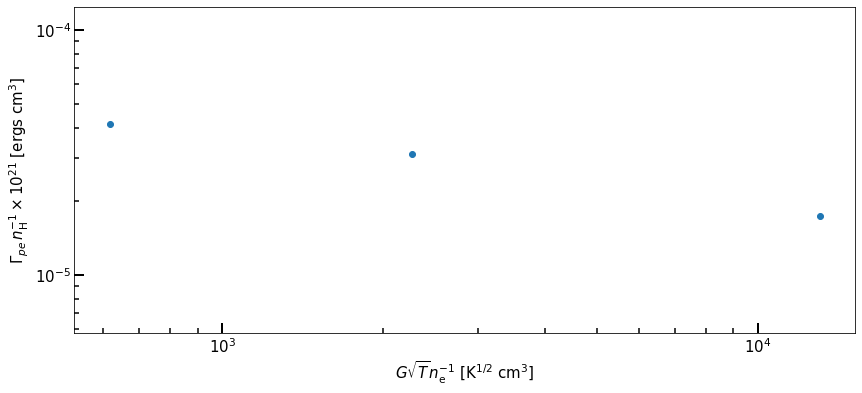

In [248]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)

ax.scatter(GTn, Gammatot)

ax.set_yscale("log")
ax.set_xscale("log")
#
ax.set_xlabel("$G\sqrt{T}n_{\mathrm{e}}^{-1}$ [K$^{1/2}$ cm$^{3}$]", fontsize=15)
ax.set_ylabel("$\Gamma_{pe}  \, n_{\mathrm{H}}^{-1} \\times 10^{21}$ [ergs cm$^{3}$]", fontsize=15)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_ylim(min(Gammatot)/3., max(Gammatot)*3.)

fig.show()


---

In [85]:
totd_s = integrate.quad(lambda x:sizedist.dnda(x, "silicate"), 3.5, 2500)
totd_c = integrate.quad(lambda x:sizedist.dnda(x, "carbonaceous"), 3.5, 2500)

In [86]:
print(totd_s)
print(totd_c)

(3.616394874572037e-08, 7.798648719395752e-09)
(6.196919970329322e-07, 1.1219924933897294e-09)


In [114]:
x = np.logspace(np.log10(3.5), np.log10(2500), num=50)
yc = sizedist.dnda(x, "carbonaceous")
ys = sizedist.dnda(x, "silicate")

yc2, ys2 =np.zeros_like(yc), np.zeros_like(ys)
for i in range(len(x)):
    yc2[i] = sizedist.dnda(x[i], "carbonaceous")
    ys2[i] = sizedist.dnda(x[i], "silicate")

In [115]:
totd_s_fix = simps(ys, x)
totd_c_fix = simps(yc, x)

In [116]:
print(totd_s_fix)
print(totd_c_fix)

3.6263885512806365e-08
6.191452811602838e-07


In [117]:
print(totd_c_fix/totd_c[0])
print(totd_s_fix/totd_s[0])

0.9991177619280771
1.0027634362549478


In [118]:
vec_Gammadot = np.vectorize(get_Gamma_dot)

In [129]:
amin, amax = 3.5, 2500
fheat = lambda grain_size, Gtot, T, ne, grain_type: 1.0e21*get_Gamma_dot(Gtot, T, ne, grain_size, grain_type)*sizedist.dnda(grain_size, grain_type)
    
Gamma_pe_sil,  err = integrate.quad(fheat, amin, amax, args=(Gtot[2], temp[2], ne[2], "silicate"))
Gamma_pe_carb, err = integrate.quad(fheat, amin, amax, args=(Gtot[2], temp[2], ne[2], "carbonaceous"))

In [180]:
x = np.logspace(np.log10(amin), np.log10(amax), num=35)
yc = sizedist.dnda(x, "carbonaceous")
ys = sizedist.dnda(x, "silicate")

In [181]:
y_Gpe_s = vec_Gammadot(Gtot[2], temp[2], ne[2], x, "silicate")*ys*1.0e21
y_Gpe_c = vec_Gammadot(Gtot[2], temp[2], ne[2], x, "carbonaceous")*yc*1.0e21

In [182]:
Gamma_pe_sil_fix = simps(y_Gpe_s, x)
Gamma_pe_carb_fix = simps(y_Gpe_c, x)

In [183]:
print(Gamma_pe_sil, Gamma_pe_sil_fix, Gamma_pe_sil/Gamma_pe_sil_fix)
print(Gamma_pe_carb, Gamma_pe_carb_fix, Gamma_pe_carb/Gamma_pe_carb_fix)
print(Gamma_pe_sil+Gamma_pe_carb, Gamma_pe_sil_fix+Gamma_pe_carb_fix, (Gamma_pe_sil+Gamma_pe_carb)/(Gamma_pe_sil_fix+Gamma_pe_carb_fix))

(7.757460599940028e-06, 7.755806663033636e-06, 1.0002132514357631)
(3.368354611678141e-05, 3.366891292013513e-05, 1.0004346204072876)
(4.144100671672144e-05, 4.142471958316876e-05, 1.0003931742620487)


In [128]:
print(Gamma_pe_sil, Gamma_pe_sil_fix, Gamma_pe_sil/Gamma_pe_sil_fix)
print(Gamma_pe_carb, Gamma_pe_carb_fix, Gamma_pe_carb/Gamma_pe_carb_fix)
print(Gamma_pe_sil+Gamma_pe_carb, Gamma_pe_sil_fix+Gamma_pe_carb_fix, (Gamma_pe_sil+Gamma_pe_carb)/(Gamma_pe_sil_fix+Gamma_pe_carb_fix))

(4.829921441701461e-06, 4.829955081134816e-06, 0.9999930352492333)
(2.6255201123034817e-05, 2.6254575973482162e-05, 1.000023811070241)
(3.108512256473628e-05, 3.108453105461698e-05, 1.0000190290829307)


In [135]:
print(Gamma_pe_sil, Gamma_pe_sil_fix, Gamma_pe_sil/Gamma_pe_sil_fix)
print(Gamma_pe_carb, Gamma_pe_carb_fix, Gamma_pe_carb/Gamma_pe_carb_fix)
print(Gamma_pe_sil+Gamma_pe_carb, Gamma_pe_sil_fix+Gamma_pe_carb_fix, (Gamma_pe_sil+Gamma_pe_carb)/(Gamma_pe_sil_fix+Gamma_pe_carb_fix))

(7.757460599940028e-06, 7.75795762046286e-06, 0.9999359341018413)
(3.368354611678141e-05, 3.368595117514723e-05, 0.9999286035192144)
(4.144100671672144e-05, 4.144390879561009e-05, 0.9999299757437706)


In [278]:
def get_Gamma_tot_FixInt(amin, amax, numint=35):

    x = np.logspace(np.log10(amin), np.log10(amax), num=numint)
    yc = sizedist.dnda(x, "carbonaceous")
    ys = sizedist.dnda(x, "silicate")

    y_Gpe_s = vec_Gammadot(Gtot[1], temp[1], ne[1], x, "silicate")*ys*1.0e21
    y_Gpe_c = vec_Gammadot(Gtot[1], temp[1], ne[1], x, "carbonaceous")*yc*1.0e21

    Gamma_pe_sil_fix = simps(y_Gpe_s, x)
    Gamma_pe_carb_fix = simps(y_Gpe_c, x)
    
    Gamma_tot= Gamma_pe_sil_fix + Gamma_pe_carb_fix
    
    return Gamma_tot

In [279]:
Gtt0 = get_Gamma_tot(Gtot[1], temp[1], ne[1])

In [280]:
Gttfix = get_Gamma_tot_FixInt(3.5, 2500, numint=20)

print("Relative diff", abs((Gtt0 - Gttfix)/Gtt0*100.))

('Relative diff', 0.3514510586821726)


---

# Now, the full calculation of the photoelectric heating.

In [204]:
NH2 = np.zeros_like(nH)
for i in range(3):
    NH2[i] = fz.get_NH2(fH2shield[i], temp[i])

In [309]:
phase = 0
grain_size = 5.0
grain_type = "silicate"


def netHeating_full(grain_size, grain_type, nH, temp, xe, xH2, Ntot, NH2, G0=1.7, save_output=False, outdir="default"):
    """
    Perform the full calculation of the net heating by a single grain given the ISM ambient parameters.
    """
    import cPickle as pickle
    import compute_charge_dist as fz
    import numpy as np
    import PeHeat_Functions as peh
    
    #Full calculation of the net heating by a grain at a given cell.
    Qabs = fz.get_QabsTable(grain_type, grain_size)

    #print("Running grain size %i, "%(grain_size))

    zeta = fz.get_zeta(NH2)

    # Compute the charge distribution.
    ############################################################################################
    Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH, nH*1.0e-4], [xe, 1.0e4*min(xe, 1.0e-4)], xH2, temp, zeta, grain_size, Ntot, grain_type, Qabs, G0=G0)
    JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH, zeta, grain_size, grain_type, Qabs)

    zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, ZZall, grain_size, grain_type)
    new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH, nH*1.0e-4], [xe, 1.0e4*min(xe, 1.0e-4)], temp, grain_size, Ntot, grain_type, Qabs, zeta, zeq=zeq, G0=G0, includeCR=True)    
    
    ffzCR, ZZfz            = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)

    # Compute the minimum and maximum allowd charges by this grain
    Zmin, Zmax = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
    Znum       = int(Zmax + abs(Zmin) +1)
    ZZ_all     = np.linspace(Zmin, Zmax, num=Znum)

    Gamma_dotdot_Z = np.zeros_like(ZZ_all, dtype=np.float)

    for i in range(Znum):
        Gamma_dotdot_Z[i] = peh.get_Gamma_pe_dotdot(grain_size, ZZ_all[i], grain_type, Ntot, Qabs)    

    Cooling = peh.Cool_per_Grain(grain_size, grain_type, ZZfz, ffzCR, nH, xe, temp)

    Av = Ntot/1.87e21
    
    Geff = G0*np.exp(-2.5*Av)
    G_CR = fz.get_G_CR(NH2)
    
    Gtot = Geff+G_CR
    
    Heating = peh.Gamma_per_grain(ZZ_all, Gamma_dotdot_Z, ZZfz, ffzCR, Gtot)

    netHeating = Heating - Cooling
    
    if save_output:
        if nH < 1.0:
            phase = "WNM"
        elif nH>1.0 and nH<100:
            phase = "CNM"
        else:
            phase = "CMM"
        
        if outdir == "default":
            outdir = "/home/jcibanezm/codes/run/PeHeat"
            
        filename = "%s/TotalHeating_ISM%s_%s_%.4iAA.pkl"%(outdir, phase, grain_type, grain_size)
        
        dictionary = {"info":"Saving the Heating, Cooling, charge array and charge distribution."}
        dictionary["netHeating"] = netHeating
        dictionary["Cooling"] = Cooling
        dictionary["grain_size"] = grain_size
        dictionary["grain_type"] = grain_type
        dictionary["ffz"] = ffzCR
        dictionary["ZZ"] = ZZfz
        dictionary["nH"] = nH
        dictionary["temp"] = temp
        dictionary["Geff"] = Geff
        dictionary["Gtot"] = Gtot
        dictionary["zeta"] = zeta
        dictionary["Ntot"] = Ntot
        dictionary["NH2"] = NH2
        dictionary["ne"] = ne
        dictionary["xH2"] = xH2

        outfile = open('%s'%(filename), 'wb')
        pickle.dump(dictionary, outfile)
        outfile.close()
        
        #print("Saving the heating, cooling, charge array and charge distribution array to file %s"%filename)
    
    #return netHeating, Cooling, ZZfz, ffzCR
    return netHeating

In [300]:
grain_size = 10.0
grain_type = "carbonaceous"

heat = netHeating_full(grain_size, grain_type, nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], save_output=False)

In [301]:
def get_Gamma_tot_Full(nH, temp, xe, xH2, Ntot, NH2, amin, amax, G0=1.7, numint=35, save_output=False, outdir="default"):
    """
    Returns GammaTot*1.0e21
    """
    
    import dust_size_dist as sizedist
    from scipy.integrate import simps
    
    x = np.logspace(np.log10(amin), np.log10(amax), num=numint)
    yc = sizedist.dnda(x, "carbonaceous")
    ys = sizedist.dnda(x, "silicate")

    for grain_size in x:
        y_Gpe_s = netHeating_full(grain_size, "silicate", nH, temp, xe, xH2, Ntot, NH2, G0=G0, save_output=save_output, outdir=outdir)*ys*1.0e21
        y_Gpe_c = netHeating_full(grain_size, "carbonaceous", nH, temp, xe, xH2, Ntot, NH2, G0=G0, save_output=save_output, outdir=outdir)*yc*1.0e21

    Gamma_pe_sil_fix  = simps(y_Gpe_s, x)
    Gamma_pe_carb_fix = simps(y_Gpe_c, x)
    
    Gamma_tot= Gamma_pe_sil_fix + Gamma_pe_carb_fix
    
    return Gamma_tot

In [302]:
#Gtot_WNM = get_Gamma_tot_Full(nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], 3.5, 15, numint=3, save_output=True)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [307]:
#Gtot_WNM = get_Gamma_tot_Full(nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], 1588, 2500, numint=3, save_output=False)

KeyboardInterrupt: 

In [310]:
#Gtot_WNM = get_Gamma_tot_Full(nH[0], temp[0], xe[0], xH2[0], Ntot[0], NH2[0], 3.5, 2500, numint=30, save_output=True)
Gtot_CNM = get_Gamma_tot_Full(nH[1], temp[1], xe[1], xH2[1], Ntot[1], NH2[1], 3.5, 2500, numint=30, save_output=True)
Gtot_CMM = get_Gamma_tot_Full(nH[2], temp[2], xe[2], xH2[2], Ntot[2], NH2[2], 3.5, 2500, numint=30, save_output=True)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. 

In [ ]:
# Loop !!!

In [ ]:
# Calculate the charge distribution.



# Calculate the heating rate per photoelectron

# Sum the products

# do it for 50 points in the size distribution.

# Integrate over the size distribution.